Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
---> Epoch 0
ave mse 1.956 ===> Total training time: 0.155 seconds.
---> Epoch 1
ave mse 1.806 ===> Total training time: 0.384 seconds.
---> Epoch 2
ave mse 1.705 ===> Total training time: 0.623 seconds.
---> Epoch 3
ave mse 1.625 ===> Total training time: 0.857 seconds.
---> Epoch 4
ave mse 1.558 ===> Total training time: 1.09 seconds.
---> Epoch 5
ave mse 1.497 ===> Total training time: 1.325 seconds.
---> Epoch 6
ave mse 1.442 ===> Total training time: 1.557 seconds.
---> Epoch 7
ave mse 1.391 ===> Total training time: 1.814 seconds.
---> Epoch 8
ave mse 1.344 ===> Total training time: 2.054 seconds.
---> Epoch 9
ave mse 1.3 ===> Total training time: 2.289 seconds.
---> Epoch 10
ave mse 1.258 ===> Total training time: 2.527 seconds.
---> Epoch 11
ave mse 1.219 ===> Total training time: 2.782 seconds.
---> Epoch 12
ave mse 1.181 ===> Total training time: 3.

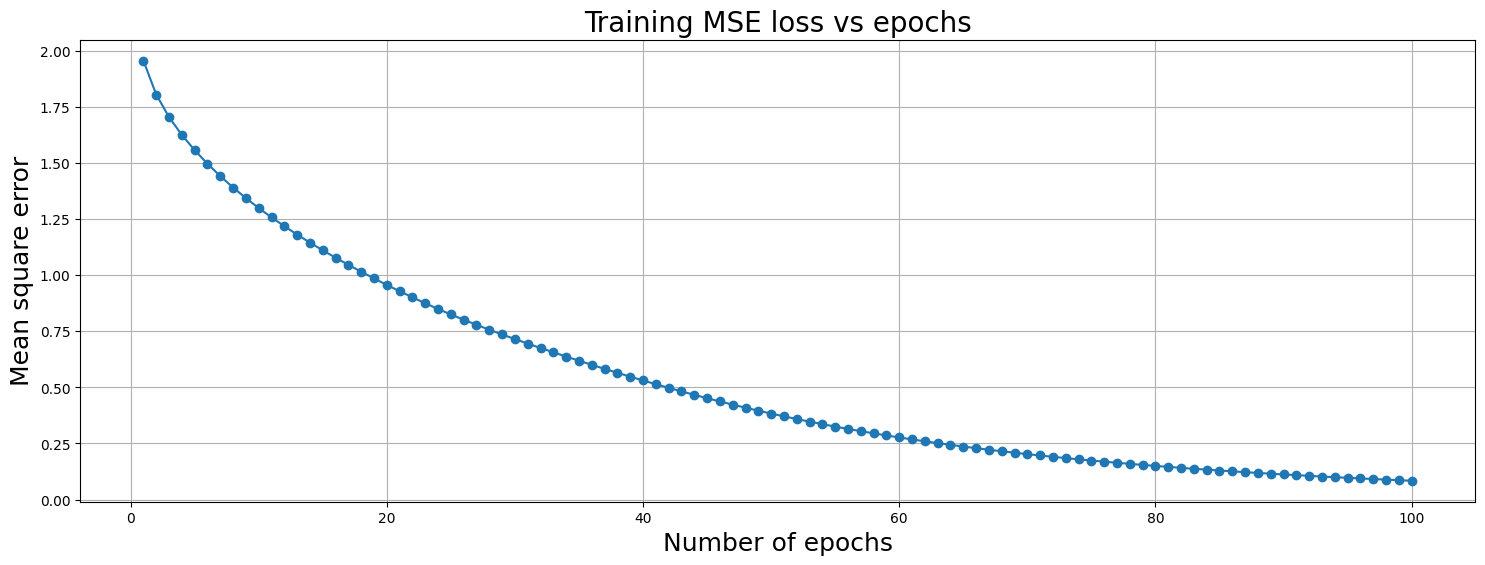

In [10]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/train.csv')

# Load test data from Google Drive
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# Column names of the dataset
user_col, name_col, rating_col = 'user_id', 'name', 'stars'

# Filter training data: Keep only users and items with minimum interactions
filtered_df = df.groupby(user_col).filter(lambda x: len(x) >= 5)
filtered_df = filtered_df.groupby(name_col).filter(lambda x: len(x) >= 5)

# Reduce dataset size: Limit to 10,000 rows to save memory
filtered_df = filtered_df.sample(n=10000, random_state=42)
filtered_df = filtered_df[filtered_df[name_col] != 'Apple Store']

# Convert user_id and name to numeric values
user_ids, user_names = pd.factorize(filtered_df[user_col])
name_ids, name_labels = pd.factorize(filtered_df[name_col])
ratings_data = filtered_df[rating_col].values.astype(np.int32)

# Create a CSR matrix for training data
ratings = csr_matrix(
    (ratings_data, (user_ids, name_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(name_ids)))
).toarray()

# Convert to DataFrame
user_item_matrix = pd.DataFrame(ratings, index=user_names, columns=name_labels)

class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.alpha = alpha
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self):
        self.now = time.time()
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time() - self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return self.user_vecs, self.item_vecs

    def filled_user_item_matrix(self):
        filled_matrix = np.zeros((self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                filled_matrix[u, i] = self.predict(u, i)
        return pd.DataFrame(filled_matrix, index=user_names, columns=name_labels)

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("Training MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean square error', fontsize=18)
        plt.grid()
        plt.show()

# 모델 초기화 및 학습
obj = MatrixFactorization(ratings)
obj.fit()

# 채워진 사용자-아이템 매트릭스 반환
filled_user_item_matrix = obj.filled_user_item_matrix()


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
filled_user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4.133877,3.488505,4.202582,4.219382,2.468920,3.392196,2.638126,3.299247,4.097860,4.289876,...,2.887711,4.173300,2.327114,4.167946,3.314490,4.170622,2.468439,3.742535,3.888510,4.170827
TFw7YRiyl4r2nw3_JFh2Ww,3.223400,2.478739,3.303393,3.316274,1.573764,2.483562,1.705693,2.392030,3.192900,3.389969,...,1.978803,3.268516,1.418715,3.268008,2.406217,3.262655,1.553642,2.841892,2.981145,3.258893
_BcWyKQL16ndpBdggh2kNA,4.206029,3.572255,4.634340,4.305954,2.860189,3.458536,2.885479,3.418831,4.168909,4.359206,...,2.943402,4.214923,2.351618,4.222243,3.375385,4.235338,2.505098,3.795622,3.954082,4.220804
NAtkmn07-dNVA6YMqZCs6Q,4.671017,4.028257,4.756955,4.780400,2.982646,3.926088,3.150626,3.836749,4.644301,4.822896,...,3.425655,4.710800,2.874358,4.709744,3.854979,4.707287,2.997190,4.284338,4.425081,4.707985
UaHRbDqkiCPZPZpymIziHQ,3.515892,2.876058,3.582262,3.618673,1.035796,2.763540,2.069438,2.685041,3.480096,3.676277,...,2.274039,3.560591,1.712770,3.551428,2.710935,3.546861,1.846139,3.133597,3.268141,3.556685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,3.228325,2.591156,3.321795,3.315770,1.566557,2.452753,1.736528,2.405011,3.196808,3.361889,...,1.976845,3.256206,1.415853,3.253875,2.404386,3.259539,1.551566,2.827522,2.979045,3.260488
UIeRnK42UJm0_drjF3IpcA,2.706059,2.051989,2.798126,2.786046,1.009139,1.957264,1.078965,1.880641,2.692543,2.871679,...,1.460604,2.744641,0.915789,2.752974,1.890879,2.741062,1.035853,2.324327,2.464360,2.753316
UCUiESd5WPj4c3CkyOIi5Q,4.811500,4.190268,4.892705,4.901654,3.136559,4.079546,3.284875,3.976706,4.778294,4.967072,...,3.565762,4.850056,3.016416,4.849895,3.991746,4.847782,3.147040,4.421356,4.567427,4.847894
cTjFQS2Yyuc27rH0zQ2gyg,5.444589,4.806490,5.530463,5.533729,3.708517,4.638410,3.821330,4.625031,5.410504,5.602821,...,4.188750,5.479708,3.632694,5.483390,4.626680,5.475509,3.757879,5.050938,5.196190,5.489460


In [13]:
user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TFw7YRiyl4r2nw3_JFh2Ww,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_BcWyKQL16ndpBdggh2kNA,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAtkmn07-dNVA6YMqZCs6Q,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UaHRbDqkiCPZPZpymIziHQ,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UIeRnK42UJm0_drjF3IpcA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UCUiESd5WPj4c3CkyOIi5Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cTjFQS2Yyuc27rH0zQ2gyg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# 학습된 사용자와 아이템 벡터 가져오기
user_vecs, item_vecs = obj.result()

# 테스트 데이터 준비
test_user_ids, _ = pd.factorize(test_df[user_col])
test_item_ids, _ = pd.factorize(test_df[name_col])
test_ratings = pd.to_numeric(test_df[rating_col], errors='coerce').fillna(0).values

# 테스트 세트에 대한 예측 계산
predictions = [
    np.clip(obj.predict(test_user_ids[i], test_item_ids[i]), 1, 5)
    if (test_user_ids[i] < len(user_vecs) and test_item_ids[i] < len(item_vecs))
    else np.nan
    for i in range(len(test_user_ids))
]

# 테스트 세트에 대한 예측 평가
test_df['predicted_rating'] = predictions
mse = ((pd.to_numeric(test_df[rating_col], errors='coerce') - test_df['predicted_rating']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# 랜덤 사용자 선택 후 상위 3개 추천 항목 출력
random_user = np.random.choice(test_user_ids)
item_scores = [(i, np.clip(obj.predict(random_user, i), 1, 5)) for i in range(len(item_vecs))]
not_sorted_item_scores = item_scores
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

k = 5
recommendation_items = []
print(f"\nTop {k} recommendations for user {random_user}:")
for idx, score in item_scores[:k]:
    recommendation_items.append(item_scores[idx][0])
    print(f"Restaurant: {name_labels[idx]}, Predicted Rating: {score}")

Test RMSE: 1.7033818091193709

Top 5 recommendations for user 2670:
Restaurant: Nothing Bundt Cakes, Predicted Rating: 5.0
Restaurant: Fritz's Bakery, Predicted Rating: 5.0
Restaurant: Angelo's Pizzeria, Predicted Rating: 5.0
Restaurant: Mediterranean Grill, Predicted Rating: 5.0
Restaurant: La Estrella Bakery, Predicted Rating: 5.0


In [15]:
# evaluation
print('\n')
random_user_name = test_df['user_id'][random_user]
print('random user index:', random_user)
print('random user name:', random_user_name)
print('items that user rated:\n', test_df[test_df['user_id'] == random_user_name])
print('recommendated items: ', recommendation_items)
print('\n')

# predicted ratings의 평가
# mse and rmse
print('mse: ', mse)
print('rmse: ', rmse)
print('\n')

# 랜덤한 한 유저에 대한 rank 평가
# precision@k
user_rated_items = test_df[test_df['user_id'] == random_user_name]['business_id']
true_positive = sum((item in user_rated_items for item in recommendation_items))
precision = true_positive / k
print(f'precision@{k} for user {random_user_name}: {precision}')

# recall@k
recall = true_positive / len(user_rated_items)
print(f'recall@{k} for user {random_user_name}: {recall}')



random user index: 2670
random user name: Venkat.Ch
items that user rated:
       Unnamed: 0    user_id  business_id stars                    name  \
1598        1598  Venkat.Ch         1598     4                     KFC   
2670        2670  Venkat.Ch         2670     3  Mustang Terrace Lounge   
3302        3302  Venkat.Ch         3302     4              Club Rogue   
6003        6003  Venkat.Ch         6003     4              PourHouse7   

      predicted_rating  
1598          1.800781  
2670          3.880506  
3302          3.701104  
6003          2.397727  
recommendated items:  [847, 1553, 612, 952, 426]


mse:  2.901509587638781
rmse:  1.7033818091193709


precision@5 for user Venkat.Ch: 0.0
recall@5 for user Venkat.Ch: 0.0


In [16]:
# 모든 유저에 대한 rank 평가
# Mean Average Precision@k
test_df = test_df.drop_duplicates(subset=['user_id'])  # make user ids unique
test_user_ids = test_df['user_id']
average_precision_sum = 0

for test_user_id in test_user_ids:
  test_user_indices = test_df[test_df['user_id'] == test_user_id].index
  if len(test_user_indices) <= 0: continue
  test_user_index = test_df[test_df['user_id'] == test_user_id].index[0]
  user_rated_items = test_df[test_df['user_id'] == test_user_id]['business_id']

  if test_user_index >= len(item_vecs): continue
  item_scores = [(i, obj.predict(test_user_index, i)) for i in range(len(item_vecs))]
  item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

  precision_sum = 0

  # calculate precision in range 1 to k
  for k_i in range(1,  k + 1):
      recommendation_items = []
      for idx, score in item_scores[:k_i]:
          recommendation_items.append(item_scores[idx][0])

      # calculate Average Precision
      # if item is rated by user, relevance is 1 and otherwise 0
      # 0 make Average Precision to 0 so, calculate only when relevance is 1
      if recommendation_items[k_i - 1] in user_rated_items:
        true_positive_of_i = sum((item in user_rated_items for item in recommendation_items[:k_i]))
        precision_of_i = true_positive_of_i / k_i
        precision_sum += precision_of_i

  average_precision = precision_sum / len(user_rated_items)
  average_precision_sum += average_precision

mean_average_precision = average_precision_sum / len(test_user_ids)
print(f'mean average precision@{k}: {mean_average_precision}')

mean average precision@5: 0.00020142339196992077
